# BayesianBlocksLightcurve usage example

BayesianBlocksLightcurve is capable of automatically identifying the signal and background region in a signal. It uses an iterative approach, where each iteration consists on the fitting of the background to a polynomial followed by the calculations of Bayesian blocks. After convergance, the first an last Bayesian blocks are considered the background region, while the blocks in between constitute the signal.

## Getting the data

This section gathers Fermi-GBM TTE data for a particular GRB, combines the data for all detector which triggered, and bins it into a light curve.

Fermi-GBM data is used as an example. `BayesianBlocksLightcurve` can work with an arbitrary `gdt.core.data_primitives.TimeBins` object.

In [1]:
from gdt.missions.fermi.gbm.catalogs import BurstCatalog
from gdt.missions.fermi.gbm.finders import TriggerFtp
from gdt.missions.fermi.gbm.trigdat import Trigdat
from gdt.missions.fermi.gbm.tte import GbmTte
from gdt.core.binning.unbinned import bin_by_time
from gdt.core import cache_path
from gdt.core.plot.lightcurve import Lightcurve

from pathlib import Path
import glob

In [2]:
burstcat = BurstCatalog(cached = False) #Run with True after the first time

In [3]:
gbm_cache_path = Path(cache_path)/'fermigbm'

def get_lc(burstcat_n, cache_path = gbm_cache_path):
    """
    Get the light curve for a given entry ID in the GBM GRB catalog.

    The light curve includes all triggered detectors. It is contructed based
    on TTE data binned to .032 s, and cut between 50-300 keV
    """

    # Get trigger data
    trig_id = burstcat.get_table(columns=('TRIGGER_NAME',))['TRIGGER_NAME'][burstcat_n][2:11]
    trig_finder = TriggerFtp(trig_id)
    trig_dir = Path(cache_path)/trig_id

    trig_finder.get_trigdat(trig_dir)
    trigdat = Trigdat.open(trig_dir / trig_finder.ls_trigdat()[0])

    # Convenience function to download the data for one detector
    def get_tte(det):

        trig_finder.get_tte(trig_dir, dets=det)

        tte_path = glob.glob(str(trig_dir / f"glg_tte_{det}_bn{trig_id}*.fit"))[0]

        tte = GbmTte.open(tte_path)

        return tte

    # Add the TTE data from all triggered detectors
    tte = get_tte(trigdat.triggered_detectors[0])
    tstart,tstop = tte.time_range

    for det in trigdat.triggered_detectors[1:]:

        tte_i = get_tte(det)
        tstart_i, tstop_i = tte.time_range

        tte = GbmTte.merge([tte, tte_i])

        tstart = max(tstart, tstart_i)
        tstop = min(tstop, tstop_i)

    # Bin
    phaii = tte.to_phaii(bin_by_time, .032, time_range = [(tstart, tstop)])

    # Cut in energy to standard duration calculation range
    lc = phaii.to_lightcurve(energy_range=(50, 300))
    
    return lc

Get the LC for a specific burst:

In [4]:
burstcat_n = 1 #ID the the burst to analyze
lc = get_lc(burstcat_n)

/Users/imartin5/software/gdt-core/src/gdt/core/heasarc.py:253: UserWarning: FTP access to heasarc.gsfc.nasa.gov is unreliable due to high server loads. Users should switch to HTTPS access.
  warnings.warn(


/Users/imartin5/software/miniforge3/envs/burstcube/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

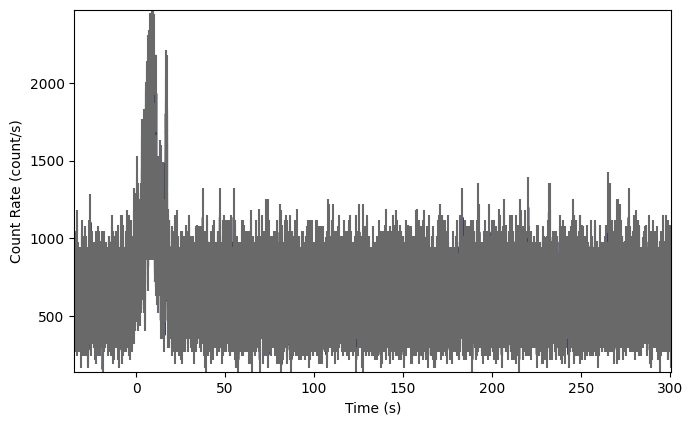

In [5]:
Lightcurve(data=lc)

Get some other useful information from the catalog

In [6]:
gbm_t90 = burstcat.get_table(columns = ('T90',))['T90'][burstcat_n]
gbm_t90_start = burstcat.get_table(columns = ('T90_START',))['T90_START'][burstcat_n]
grb_name = burstcat.get_table(columns = ('NAME',))['NAME'][burstcat_n]

# Signal identification / background fitting / duration calculation

This section performs the actual calculation:

In [7]:
# Import
from gdt.core.temporal import BayesianBlocksLightcurve
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# The main calculation
bb_lc = BayesianBlocksLightcurve(lc)
bb_lc.compute_bayesian_blocks()

Plotting:

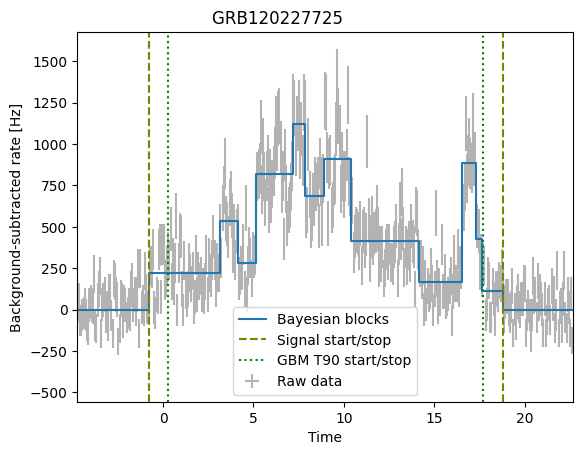

In [9]:
# Rebin to something comparable to the charateristic identified variability
rebin_dt = np.min(bb_lc.bb_lightcurve.widths)/5

ax = bb_lc.plot(rebin_dt = rebin_dt, subtract_bkg = True)

# Comparison to GBM's
ax.axvline(gbm_t90_start, color = 'green', ls = ':', label = "GBM T90 start/stop")
ax.axvline(gbm_t90_start + gbm_t90, color = 'green', ls = ':')

# Pimp the plot
ax.set_xlim(gbm_t90_start-5, gbm_t90_start + gbm_t90+5)
ax.set_title(grb_name)

ax.legend()